In [1]:
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

import numpy as np

In [2]:
my_list = [5, 8, 33, 7, 29, 3, 98, 97, 65, 1, 74, 44, 88, 13, 17, 5, 47, 55, 79, 2]
print('List =', my_list)
l = len(my_list)
print('Number of elements =', l)

qubits = int(np.ceil(np.log2(l))) # Calculates nearest integer >= log_2(l)
print('Number of working qubits =', qubits)

# Define a function to get the index of the element to find in binary
def get_binary_index(my_list, element, qubits):
    try:
        index_decimal = my_list.index(element)  # Returns the index of the element in decimal
        index_binary = format(index_decimal, f'0{qubits}b')  # Converts index to binary, formats it to same length as "qubits"
        return index_binary
    except ValueError:
        return f"Element {element} not found in the list"

element = 44  # Element we want to find
print('Element to find =', element)
index = get_binary_index(my_list, element, qubits)
print('Index =', index)

List = [5, 8, 33, 7, 29, 3, 98, 97, 65, 1, 74, 44, 88, 13, 17, 5, 47, 55, 79, 2]
Number of elements = 20
Number of working qubits = 5
Element to find = 44
Index = 01011


In [4]:
# Let us find the element "44" by Grover search.
# Grover will basically find the index associated to "44", i.e. 01011
# So, my solution |w> = |01011>

In [5]:
# Define general phase oracle (marks "w")

n = qubits # no. of working qubits
q = 2 * n - 1 # no. of total qubits needed
w = index # index string of the element we want to find ( in this case 01011)
# Replace the input "w" for different phase oracles

def phase_oracle(q,name = 'Uf'):
    qc = QuantumCircuit(q, name=name)
    
    # Copy code for the circuit constructed above
    i = n-1
    for bit in w:
        if bit == '0':
            qc.x(i)
        i-=1
    qc.ccx(0,1,n)
    for i in range(n-2):
        qc.ccx(i+2,n+i,n+i+1)
    i = n-2
    while i > 1:
        qc.ccx(i,n+i-2,n+i-1)
        i-=1
    qc.ccx(0,1,n)
    i = n-1
    for bit in w:
        if bit == '0':
            qc.x(i)
        i-=1
    return qc

In [6]:
# Define general diffuser (marks "all-zero" state |00....0>)

n = qubits # no. of working qubits
q = 2 * n - 1 # no. of total qubits needed

def diffuser(q, name='V'):
    qc = QuantumCircuit(q, name=name)
    
    for i in range(n): # first layer of Hadamards in diffuser
        qc.h(i)
    
    # Copy code for the circuit constructed above    
    for i in range(n):
        qc.x(i)
    qc.ccx(0,1,n)
    for i in range(n-2):
        qc.ccx(i+2,n+i,n+i+1)
    i = n-2
    while i > 1:
        qc.ccx(i,n+i-2,n+i-1)
        i-=1
    qc.ccx(0,1,n)
    for i in range(n):
        qc.x(i)
    
    for i in range(n): # second layer of Hadamards in diffuser
        qc.h(i)    
    return qc

r =  4


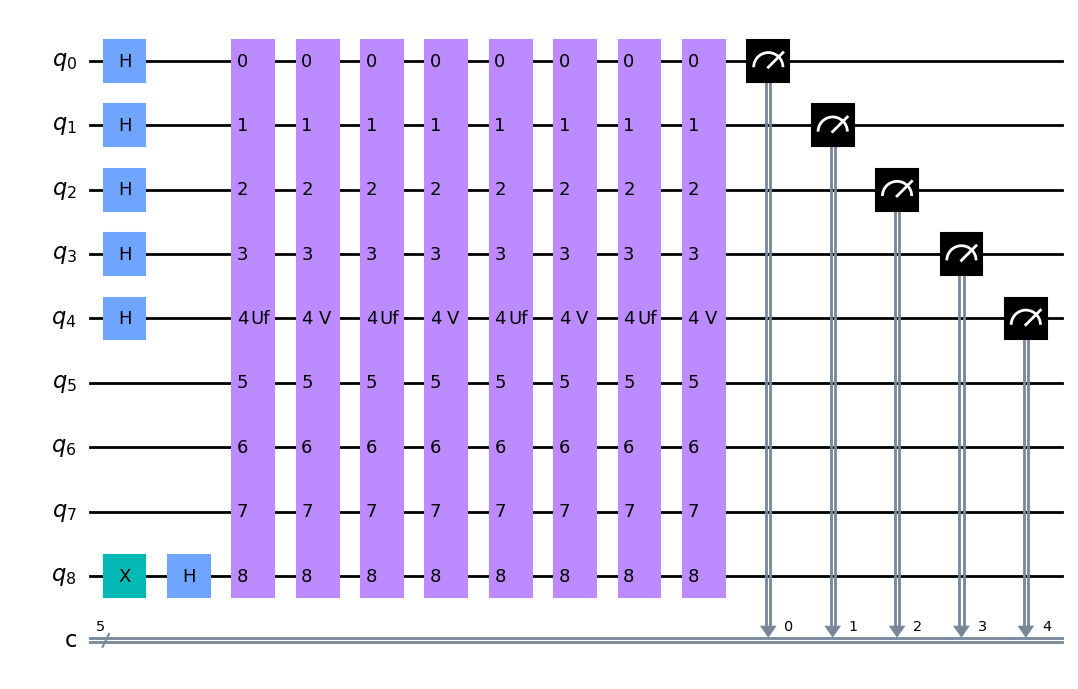

In [7]:
# We now create the Grover circuit

n = qubits # no. of working qubits
q = 2 * n - 1 # no. of total qubits needed
gr = QuantumCircuit(q,n)
mu = 1 # number of solutions

r = int(np.floor(np.pi/4*np.sqrt(2**n/mu))) # Determine r (i.e. number of iterations to make)
# Since no. of working qubits = n, here N = 2^n
print('r = ', r)

# Step 1: apply Hadamard gates on all working qubits
gr.h(range(n))   

# Put ancilla qubit in state |->
gr.x(q-1)
gr.h(q-1)
    
# Step 2: apply r rounds of the phase oracle and the diffuser
for j in range(r):
    gr.append(phase_oracle(q), range(q)) # range(q) tells the computer to add the oracle to gr in the same order of qubits, i.e. 0,1,2,...,q-1
    gr.append(diffuser(q), range(q))
        
# Step 3: measure all qubits
gr.measure(range(n), range(n))
    
gr.draw()

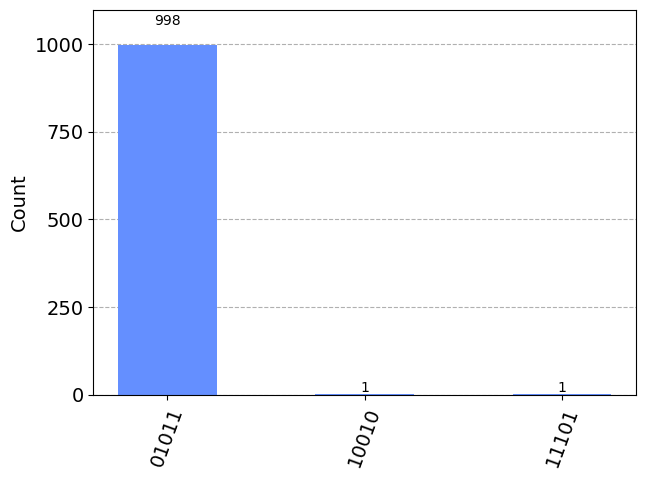

In [8]:
# Let's see the results

from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

simulator = Aer.get_backend('aer_simulator')
job = execute(gr, backend=simulator, shots=1000)
counts = job.result().get_counts()

plot_histogram(counts)

In [9]:
# We found the "01011"-indexed element. We convert it into decimal index and extract that element from my_list

In [11]:
binary_index = '01011'
decimal_index = int(binary_index, 2)
winner = my_list[decimal_index]
print("The winner element is: ", winner)

The winner element is:  44
